### Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=a69ac916bf0db702f1abebf694139af1aa743979613755559880e5a71a80556b
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 39.6 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

Now we import some of the libraries usually needed by our workload.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

### Data Preprocessing

In this Colab, we will load a famous machine learning dataset, the [Breast Cancer Wisconsin dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), using the ```scikit-learn``` datasets loader.

In [ ]:
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()

For convenience, given that the dataset is small, we first construct a Pandas dataframe, tune the schema, and then convert it into a Spark dataframe.

In [ ]:
pd_df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
df = spark.createDataFrame(pd_df)

def set_df_columns_nullable(spark, df, column_list, nullable=False):
    for struct_field in df.schema:
        if struct_field.name in column_list:
            struct_field.nullable = nullable
    df_mod = spark.createDataFrame(df.rdd, df.schema)
    return df_mod

df = set_df_columns_nullable(spark, df, df.columns)
df = df.withColumn('features', array(df.columns))
vectors = df.rdd.map(lambda row: Vectors.dense(row.features))

df.printSchema()

root
 |-- mean radius: double (nullable = false)
 |-- mean texture: double (nullable = false)
 |-- mean perimeter: double (nullable = false)
 |-- mean area: double (nullable = false)
 |-- mean smoothness: double (nullable = false)
 |-- mean compactness: double (nullable = false)
 |-- mean concavity: double (nullable = false)
 |-- mean concave points: double (nullable = false)
 |-- mean symmetry: double (nullable = false)
 |-- mean fractal dimension: double (nullable = false)
 |-- radius error: double (nullable = false)
 |-- texture error: double (nullable = false)
 |-- perimeter error: double (nullable = false)
 |-- area error: double (nullable = false)
 |-- smoothness error: double (nullable = false)
 |-- compactness error: double (nullable = false)
 |-- concavity error: double (nullable = false)
 |-- concave points error: double (nullable = false)
 |-- symmetry error: double (nullable = false)
 |-- fractal dimension error: double (nullable = false)
 |-- worst radius: double (nullable

With the next cell, we build the two data structures that we will be using throughout this Colab:


*   ```features```, a dataframe of Dense vectors, containing all the original features in the dataset;
*   ```labels```, a series of binary labels indicating if the corresponding set of features belongs to a subject with breast cancer, or not.



In [ ]:
from pyspark.ml.linalg import Vectors
features = spark.createDataFrame(vectors.map(Row), ["features"])
labels = pd.Series(breast_cancer.target)

If you run successfully the Setup and Data Preprocessing stages, you are now ready to cluster the data with the [K-means](https://spark.apache.org/docs/latest/ml-clustering.html) algorithm included in MLlib (Spark's Machine Learning library).
Set the ```k``` parameter to **2**, fit the model, and the compute the [Silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)) (i.e., a measure of quality of the obtained clustering).  

**IMPORTANT:** use the MLlib implementation of the Silhouette score (via ```ClusteringEvaluator```).

In [ ]:

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

k = 2

kmeans = KMeans().setK(k).setSeed(1)
model = kmeans.fit(features)

predictions = model.transform(features)

evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(predictions)

print("Silhouette Score:", silhouette_score)

Silhouette Score: 0.8342904262826145


Take the predictions produced by K-means, and compare them with the ```labels``` variable (i.e., the ground truth from our dataset).  

Compute how many data points in the dataset have been clustered correctly (i.e., positive cases in one cluster, negative cases in the other).

*HINT*: you can use ```np.count_nonzero(series_a == series_b)``` to quickly compute the element-wise comparison of two series.

**IMPORTANT**: K-means is a clustering algorithm, so it will not output a label for each data point, but just a cluster identifier!  As such, label ```0``` does not necessarily match the cluster identifier ```0```.


In [ ]:
import numpy as np

cluster_centers = model.clusterCenters()

def assign_cluster_labels(cluster_indic, ground_truth_labels):
    cluster_lab = []
    for cluster_index in range(len(cluster_centers)):
        cluster_data_indic = np.where(cluster_indic == cluster_index)[0]
        cluster_data_lab = ground_truth_labels[cluster_data_indic]
        class_counts = np.bincount(cluster_data_lab)
        cluster_lab = np.argmax(class_counts)
        cluster_lab.append(cluster_lab)
    return cluster_lab

cluster_indic = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
correctly_clustered = np.count_nonzero(cluster_indic == labels)

print("Number of data points clustered correctly:", correctly_clustered)


Number of data points clustered correctly: 83


Now perform dimensionality reduction on the ```features``` using [SVD](https://spark.apache.org/docs/latest/mllib-dimensionality-reduction), available as well in MLlib.

Reduce the dimensionality to **2**, effectively reducing the dataset size of a **15X** factor. Name the new dataset as ```svdFeatures```

In [ ]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="features", outputCol="svdFeatures")
pca_model = pca.fit(features)

svdFeatures = pca_model.transform(features).select("svdFeatures")
svdFeatures.show()

+--------------------+
|         svdFeatures|
+--------------------+
|[-2260.0138862925...|
|[-2368.9937557820...|
|[-2095.6652015478...|
|[-692.69051005705...|
|[-2030.2124927427...|
|[-888.28005357607...|
|[-1921.0822124748...|
|[-1074.7813350047...|
|[-908.57847816188...|
|[-861.57844940756...|
|[-1404.5591306499...|
|[-1524.2324408687...|
|[-1734.3856477464...|
|[-1162.9140032230...|
|[-903.43010304988...|
|[-1155.8759954206...|
|[-1335.7294321308...|
|[-1547.2640922523...|
|[-2714.9647651812...|
|[-908.25026718708...|
+--------------------+
only showing top 20 rows



Now run K-means with the same parameters as above, but on the ```svdFeatures``` produced by the SVD reduction you just executed.

Compute the Silhouette score, as well as the number of data points that have been clustered correctly.

In [ ]:
kmeans_svd = KMeans().setK(k).setSeed(1).setFeaturesCol("svdFeatures")
model_svd = kmeans_svd.fit(svdFeatures)

predictions_svd = model_svd.transform(svdFeatures)
evaluator_svd = ClusteringEvaluator(predictionCol="prediction", featuresCol="svdFeatures")
silhouette_score_svd = evaluator_svd.evaluate(predictions_svd)

print("Silhouette Score (SVD):", silhouette_score_svd)

Silhouette Score (SVD): 0.8348610363444832


In [ ]:

cluster_indic_svd = predictions_svd.select("prediction").rdd.flatMap(lambda x: x).collect()
correctly_clustered_svd = np.count_nonzero(cluster_indic_svd == labels)

print("Number of data points clustered correctly (SVD):", correctly_clustered_svd)

Number of data points clustered correctly (SVD): 83


#PCA Visualization (First Image):

1. This plot uses Principal Component Analysis (PCA) to reduce the data's dimensions to two components for visualization.

2. The color legend shows that purple represents benign tumors (label 0), and yellow represents malignant tumors (label 1).

3. The coloring is directly based on the actual labels of the dataset (whether a tumor is benign or malignant).

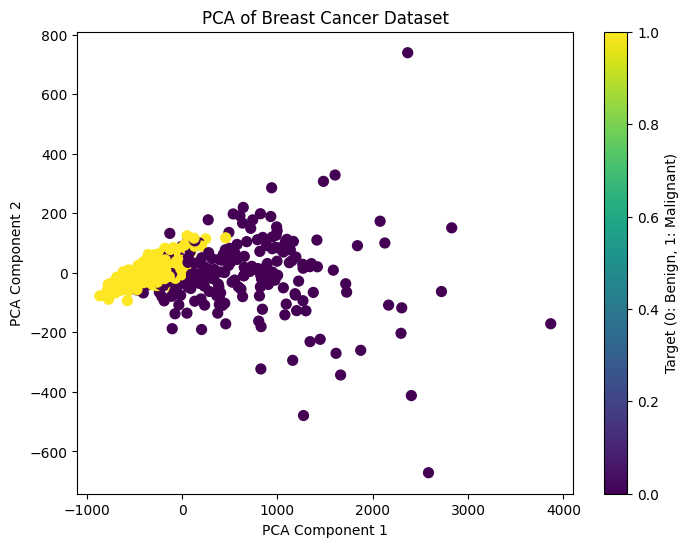

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA for visualization (reduce to 2 components)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(breast_cancer.data)

# Plot the PCA result
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=breast_cancer.target, cmap='viridis', s=50)
plt.title("PCA of Breast Cancer Dataset")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Target (0: Benign, 1: Malignant)")
plt.show()


2. K-Means Clustering Visualization (Before SVD)
Once I run K-Means, you can plot the clusters along with their centroids.

#K-Means Clustering Visualization

1. This plot shows the result of K-Means clustering, which is an unsupervised algorithm. Unlike PCA, K-Means does not know the true labels of the dataset.

2. algorithm. Unlike PCA, K-Means does not know the true labels of the dataset.
K-Means assigns its own cluster labels, and in this case, it has identified two clusters.

3. The purple cluster here might correspond to the malignant tumors from K-Means’ perspective, while the yellow cluster may correspond to benign tumors. However, since K-Means does not know the true labels, it may assign them differently than PCA.

4. The red centroids are the centers of these two clusters, and K-Means labels them based on the closest points to these centroids.

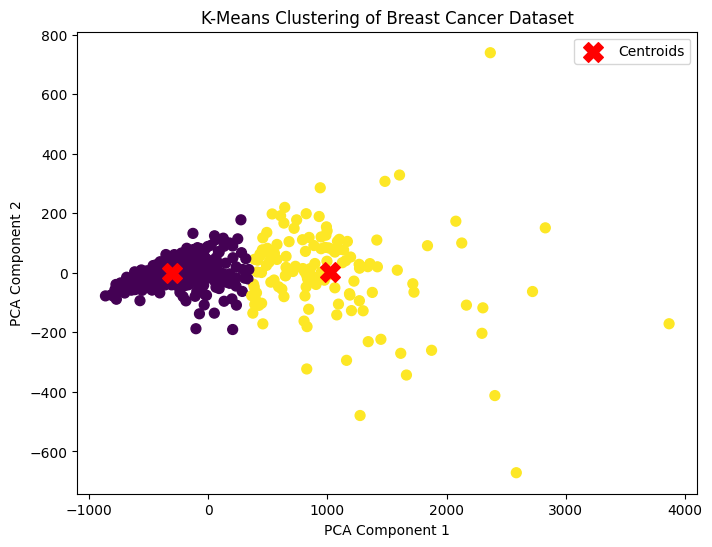

In [ ]:
# K-Means Clustering on PCA reduced data
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(pca_result)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', s=50)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title("K-Means Clustering of Breast Cancer Dataset")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


# 3. Visualization After SVD Dimensionality Reduction
This plot shows the result of Singular Value Decomposition (SVD), which reduces the data to two components. SVD works similarly to Principal Component Analysis (PCA), transforming high-dimensional data into lower dimensions for easier visualization.

Since this visualization shows the clustering results after dimensionality reduction, it divides the data into two clusters, similar to K-Means. The purple cluster might correspond to malignant tumors (or vice versa with benign), and the yellow cluster could correspond to benign tumors (or vice versa). However, SVD itself does not know the actual cluster labels; it simply compresses the data into two dimensions during the transformation process.

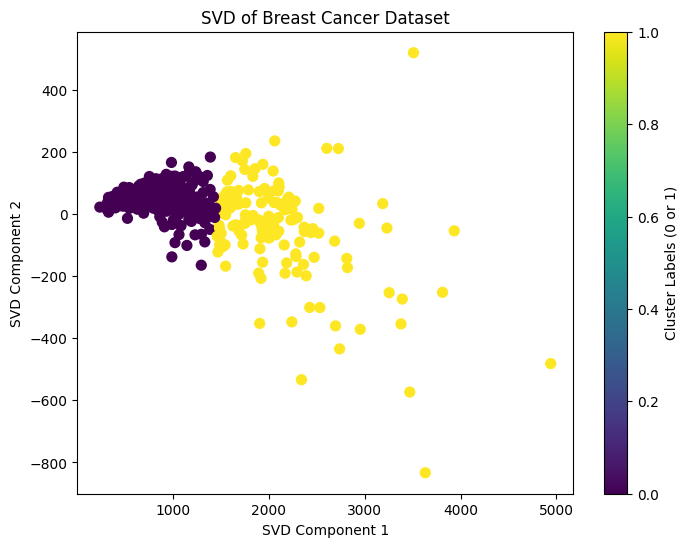

In [ ]:
# Perform SVD on the data
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
svd_result = svd.fit_transform(breast_cancer.data)

# Plot the result after SVD
plt.figure(figsize=(8, 6))
plt.scatter(svd_result[:, 0], svd_result[:, 1], c=labels, cmap='viridis', s=50)
plt.title("SVD of Breast Cancer Dataset")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.colorbar(label="Cluster Labels (0 or 1)")
plt.show()


#4. Silhouette Score Visualization

This image is a Silhouette Plot for the K-Means clustering algorithm. The Silhouette plot helps assess the quality of the clusters formed by K-Means by showing how well each data point fits within its assigned cluster.

The clustering performed by K-Means appears to be effective, with most data points having high Silhouette Coefficients (close to 1).
The red dashed line shows that the average Silhouette Score is around 0.6 to 0.7, indicating strong cluster cohesion and separation.
Some points are near the 0.0 line, which suggests they are less clearly defined in their respective clusters and may be closer to the boundary between the two clusters.

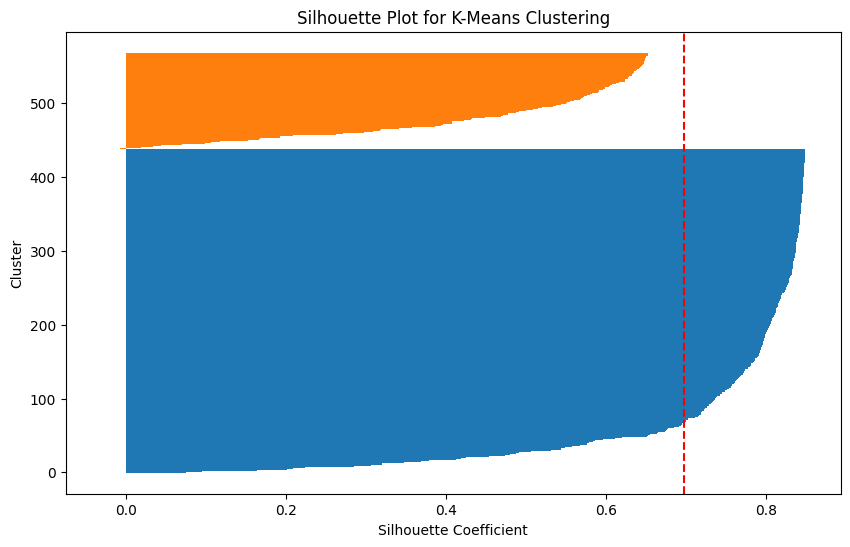

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

# Calculate the silhouette score for each point
silhouette_vals = silhouette_samples(breast_cancer.data, labels)

# Silhouette plot
plt.figure(figsize=(10, 6))
y_lower, y_upper = 0, 0
for i in range(2):  # Since K=2 clusters
    cluster_silhouette_vals = silhouette_vals[labels == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1.0)
    y_lower += len(cluster_silhouette_vals)

plt.title("Silhouette Plot for K-Means Clustering")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.axvline(silhouette_score(breast_cancer.data, labels), color='red', linestyle='--')
plt.show()
